# 1006개의 데이터로 Transfer_Learning 하기

- 논문의 모델에 1006개의 데이터를 넣고 학습을 시켜보자

## Step 1. 실험환경 set-up

#### 라이브러리 실행

In [1]:
from tensorflow.keras             import utils, regularizers
from tensorflow.keras.models      import Sequential, load_model
from tensorflow.keras.layers      import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers  import Adam
from tensorflow.keras.constraints import MaxNorm
from sklearn.model_selection      import train_test_split  # 데이터 전처리에 필요한 패키지

import os                       # I/O 관련된 작업에 필요한 패키지 
import numpy             as np  # 데이터 array 작업에 필요한 패키지
import tensorflow        as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt # 데이터 시각화에 관련된 작업에 필요한 패키지

import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지
from PIL import Image

#### 필요한 변수들 생성

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# BATCH_SIZE 변수
BATCH_SIZE = 32

# 이미지 사이즈 변수
IMAGE_SIZE = [256, 256]

# EPOCH 크기 변수
EPOCHS = 150

In [3]:
tf.config.list_physical_devices('GPU')

[]

## Step 2. 데이터 준비하기

먼저 아래의 링크에서 데이터를 다운 받을 것

https://drive.google.com/drive/folders/1Pi5qyX080zY2IdGT1TvvLraBO9DHBxJl?usp=sharing

받은 후 터미널 창에 아래의 명령어들을 차례로 입력

```
$ cd ~/Downloads && cp CellPin ~/aiffel
```

#### 데이터의 개수 확인

In [4]:
# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel/CellPin')
print(ROOT_PATH)

train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

/home/aiffel-dj52/aiffel/CellPin
782
104
126


#### train과 validation을 80:20으로 분할

In [5]:
# filenames = tf.io.gfile.glob(str(ROOT_PATH + '/train/*/*'))
# filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/val/*/*')))

# train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

# print(len(train_filenames))
# print(len(val_filenames))

#### train 데이터 안에 정상 이미지 수와 CPE 이미지 수

In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "normal" in filename])
print("NORMAL images count in training set: " + str(COUNT_NORMAL))

COUNT_CPE = len([filename for filename in train_filenames if "cpe" in filename])
print("CPE images count in training set: " + str(COUNT_CPE))

NORMAL images count in training set: 355
CPE images count in training set: 427


#### val 데이터 안에 정상 이미지 수와 CPE 이미지 수

In [7]:
COUNT_NORMAL = len([filename for filename in val_filenames if "normal" in filename])
print("NORMAL images count in training set: " + str(COUNT_NORMAL))

COUNT_CPE = len([filename for filename in val_filenames if "cpe" in filename])
print("CPE images count in training set: " + str(COUNT_CPE))

NORMAL images count in training set: 50
CPE images count in training set: 76


#### test 데이터 안에 정상 이미지 수와 CPE 이미지 수

In [8]:
COUNT_NORMAL = len([filename for filename in test_filenames if "normal" in filename])
print("NORMAL images count in training set: " + str(COUNT_NORMAL))

COUNT_CPE = len([filename for filename in test_filenames if "cpe" in filename])
print("CPE images count in training set: " + str(COUNT_CPE))

NORMAL images count in training set: 40
CPE images count in training set: 64


#### tf.data 인스턴스를 만들기

In [9]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

#### train data와 val data의 개수 확인

In [10]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 782
Validating images count: 126


#### 라벨 이름들 확인

In [11]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/train/*"))])
print(CLASS_NAMES)

['cpe' 'normal']


#### 라벨링 함수를 만들어 보기

In [12]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "cpe"

#### decode_img 함수와 process_path 함수를 만들기

In [13]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    if label == True:
        label = ([0, 1])
    else:
        label = ([1, 0])
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

#### train과 val에 함수들 적용해주기

In [14]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [15]:
train_ds

<ParallelMapDataset shapes: ((256, 256, 3), (2,)), types: (tf.float32, tf.int32)>

#### 전처리 함수 만들기 및 적용

In [16]:
# def augment_LR(image,label):
#     image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
#     return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    
#     ds = ds.map(
#             augment_LR,       # augment 함수 적용
#             num_parallel_calls=2
#         )    

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

#### Image shape를 변경 체크하기

In [17]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy().shape)

Image shape:  (32, 256, 256, 3)
Label:  (32, 2)


#### test 데이터 셋도 만들어 보기 & 데이터의 갯수 확인

In [18]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

104


## Step 3. 데이터 시각화

#### 16개의 샘플 꺼내서 확인

In [19]:
# image_batch, label_batch = next(iter(train_ds))

# def show_batch(image_batch, label_batch):
#     plt.figure(figsize=(10,10))
#     for n in range(16):
#         ax = plt.subplot(4,4,n+1)
#         plt.imshow(image_batch[n])
#         if list(label_batch[n])[0].numpy() == 0:
#             plt.title("CPE")
#         else:
#             plt.title("NORMAL")
#         plt.axis("off")

# show_batch(image_batch.numpy(), label_batch)

#### model building

In [40]:
vgg_layer = tf.keras.applications.VGG19(include_top = False,
                                        weights = "imagenet",
                                        input_shape = (256, 256, 3),
                                        classes = 2,
                                        classifier_activation = "softmax")

fc_layer = [
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(4096),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(4096),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(2),
    tf.keras.layers.Activation('softmax')
]

In [41]:
vgg_layer.trainable

True

In [42]:
vgg_layer.trainable = False
vgg_layer.trainable

False

In [43]:
vgg19 = tf.keras.models.Sequential([vgg_layer] + fc_layer)

In [44]:
vgg19.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 4096)              134221824 
_________________________________________________________________
activation_6 (Activation)    (None, 4096)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
activation_7 (Activation)    (None, 4096)             

In [45]:
vgg19.layers[0].trainable

False

## Step 5. 데이터 imbalance 처리

#### 이 weight들은 'Normal'과 'Cpe' 전체 데이터 건수에 반비례하도록 설정

In [46]:
# weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
# weight_for_1 = (1 / COUNT_CPE)*(TRAIN_IMG_COUNT)/2.0

# class_weight = {0: weight_for_0, 1: weight_for_1}

# print('Weight for class 0: {:.2f}'.format(weight_for_0))
# print('Weight for class 1: {:.2f}'.format(weight_for_1))

## Step 6. 모델 훈련

#### GPU사용하여 model complie

In [47]:
with tf.device('/GPU:0'):
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    vgg19.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 2, restore_best_weights = True)
    check_point = tf.keras.callbacks.ModelCheckpoint(ROOT_PATH + '/pre_training_model/best_model_vgg19_1.h5')

#### 모델 fitting

In [48]:
with tf.device('/GPU:0'):
    history = vgg19.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=1,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
#         class_weight=class_weight,
        callbacks=[check_point]
    )

24/24 [==============================] - 170s 6s/step - loss: 4.8685 - accuracy: 0.6719 - precision: 0.6719 - recall: 0.6719 - val_loss: 0.4974 - val_accuracy: 0.7500 - val_precision: 0.7500 - val_recall: 0.7500


## Step 7. 결과 확인 및 시각화

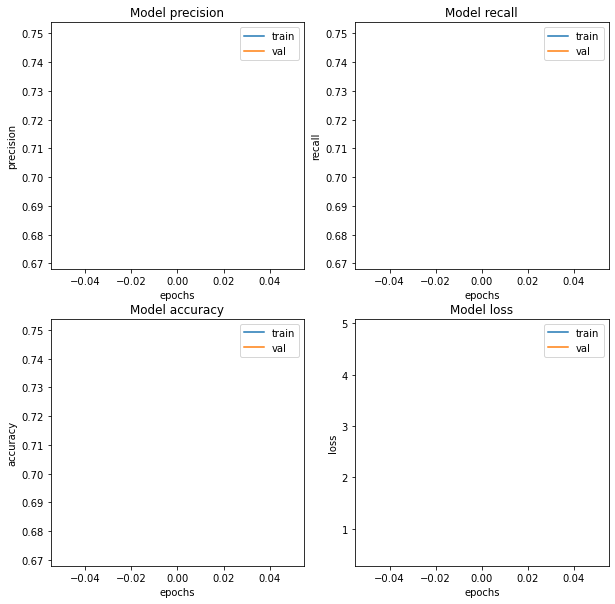

In [49]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

## Step 8. 최종 Test dataset 검정하기

In [50]:
vgg19 = tf.keras.models.load_model(ROOT_PATH + '/pre_training_model/best_model_vgg19_1.h5')
loss, acc, prec, rec = vgg19.evaluate(test_ds)

4/4 [==============================] - 14s 3s/step - loss: 0.4343 - accuracy: 0.8269 - precision: 0.8269 - recall: 0.8269


## Discussion

In [51]:
vgg19.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 4096)              134221824 
_________________________________________________________________
activation_6 (Activation)    (None, 4096)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
activation_7 (Activation)    (None, 4096)             

In [ ]:
vgg19.layers[0].trainable = True
vgg19.layers[0].trainable

In [54]:
vgg19.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 4096)              134221824 
_________________________________________________________________
activation_6 (Activation)    (None, 4096)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
activation_7 (Activation)    (None, 4096)             

In [ ]:
with tf.device('/GPU:0'):
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    vgg19.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5),
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 2, restore_best_weights = True)
    check_point = tf.keras.callbacks.ModelCheckpoint(ROOT_PATH + '/pre_training_model/best_model_vgg19_ft.h5')

In [ ]:
with tf.device('/GPU:0'):
    history = vgg19.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
#         class_weight=class_weight,
        callbacks=[check_point]
    )

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
vgg19 = tf.keras.models.load_model(ROOT_PATH + '/pre_training_model/best_model_vgg19_ft.h5')
loss, acc, prec, rec = vgg19.evaluate(test_ds)